Processing test: 100%|██████████| 174/174 [04:58<00:00,  1.72s/it]


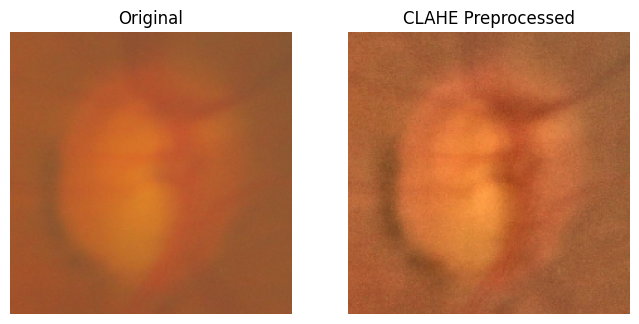

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Paths (update for your environment)
BASE_DIR = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital"
TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "training_set")
TEST_IMAGE_DIR = os.path.join(BASE_DIR, "test_set")
TRAIN_CSV = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/train_labels.csv"
TEST_CSV = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/test_labels.csv"
OUTPUT_DIR = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/"
IMG_SIZE = (224, 224)

# Create output directories
os.makedirs(os.path.join(OUTPUT_DIR, 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'test'), exist_ok=True)

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))

# CLAHE preprocessing
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

# Preprocess and save images
def process_and_save(df, split):
    label_list = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
        img_path = row['filepath']
        label = row['label']
        filename = os.path.basename(img_path)

        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            img = apply_clahe(img)
            save_path = os.path.join(OUTPUT_DIR, split, filename)
            cv2.imwrite(save_path, img)
            label_list.append((filename, label))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    pd.DataFrame(label_list, columns=['filename', 'label']).to_csv(
        os.path.join(OUTPUT_DIR, f"{split}_labels.csv"), index=False
    )

# Run preprocessing
process_and_save(train_df, 'train')
process_and_save(test_df, 'test')

# Display a sample CLAHE image
sample_img_path = train_df.iloc[0]['filepath']
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.resize(sample_img, IMG_SIZE)
clahe_img = apply_clahe(sample_img)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("CLAHE Preprocessed")
plt.imshow(cv2.cvtColor(clahe_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Path to original label CSV
csv_path = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/train_labels.csv"
df = pd.read_csv(csv_path)

# Split by class
df_healthy = df[df['label'] == 0]
df_glaucoma = df[df['label'] == 1]

# Match class sizes (undersample the majority class)
min_class_size = min(len(df_healthy), len(df_glaucoma))
df_healthy_bal = df_healthy.sample(n=min_class_size, random_state=42)
df_glaucoma_bal = df_glaucoma.sample(n=min_class_size, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_healthy_bal, df_glaucoma_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save new balanced CSV
balanced_csv_path = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/balanced_train.csv"
df_balanced.to_csv(balanced_csv_path, index=False)

print(f"✅ Saved balanced dataset with {len(df_balanced)} images to:\n{balanced_csv_path}")


✅ Saved balanced dataset with 232 images to:
/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/balanced_train.csv


Loading images: 100%|██████████| 232/232 [00:03<00:00, 65.13it/s]


✅ Train: 185 | Test: 47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,860,801 (37.62 MB)

 Trainable params: 9,859,841 (37.61 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6018 - loss: 3.9851 - val_accuracy: 0.4894 - val_loss: 0.6881
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.6257 - loss: 5.1678 - val_accuracy: 0.5319 - val_loss: 0.7075
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.5805 - loss: 4.4601 - val_accuracy: 0.4894 - val_loss: 0.9476
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.7209 - loss: 3.1726 - val_accuracy: 0.5957 - val_loss: 0.6223
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.7213 - loss: 3.9116 - val_accuracy: 0.5319 - val_loss: 0.7767
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - accuracy: 0.6614 - loss: 4.5858 - val_accuracy: 0.4894 - val_loss: 1.3903
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.7499 - loss: 2.8187 - val_accuracy: 0.4894 - val_loss: 4.1102
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.7474 - loss: 3.4273 - val_accuracy: 0.4894 - val_loss: 6

✅ Model saved at: /content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma_cnn_balanced.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
✅ Test Accuracy: 0.5957
              precision    recall  f1-score   support

     Healthy       0.69      0.38      0.49        24
    Glaucoma       0.56      0.83      0.67        23

    accuracy                           0.60        47
   macro avg       0.63      0.60      0.58        47
weighted avg       0.63      0.60      0.57        47



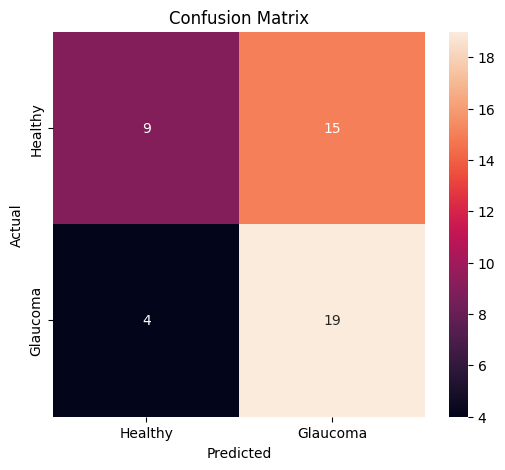

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# -------------------
# 🔧 Settings
# -------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

CSV_PATH = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/balanced_train.csv"
IMAGE_DIR = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/training_set"
MODEL_SAVE_PATH = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma_cnn_balanced.h5"

# -------------------
# 📥 Load Data
# -------------------
def load_images_from_csv(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading images"):
        img_path = os.path.join(image_dir, row['filename'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Could not read: {img_path}")
            continue
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(int(row['label']))  # 0 or 1
    X = np.array(X) / 255.0
    y = np.array(y)
    return X, y

X, y = load_images_from_csv(CSV_PATH, IMAGE_DIR)

# -------------------
# ✂️ Train-Test Split (Stratified)
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"✅ Train: {len(y_train)} | Test: {len(y_test)}")

# -------------------
# 🧪 Data Augmentation
# -------------------
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# -------------------
# 🧠 CNN Model
# -------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------
# 🏋️ Train
# -------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    shuffle=True
)

# Save model
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# -------------------
# 📊 Evaluation
# -------------------
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred_classes)
print(f"✅ Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_classes, target_names=["Healthy", "Glaucoma"]))

# 📌 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Healthy", "Glaucoma"], yticklabels=["Healthy", "Glaucoma"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# 📁 Your combined disc/cup masks folder
MASK_FOLDER = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted"
SAVE_FOLDER = os.path.join(MASK_FOLDER, "combined_masks")
os.makedirs(SAVE_FOLDER, exist_ok=True)

# 🧠 Collect filenames by type
cup_files = [f for f in os.listdir(MASK_FOLDER) if "_optic-cup.png" in f]

for cup_file in tqdm(cup_files):
    base = cup_file.replace("_optic-cup.png", "")
    disc_file = base + "_optic-disc.png"

    cup_path = os.path.join(MASK_FOLDER, cup_file)
    disc_path = os.path.join(MASK_FOLDER, disc_file)

    # Load masks
    cup_mask = cv2.imread(cup_path, cv2.IMREAD_GRAYSCALE)
    disc_mask = cv2.imread(disc_path, cv2.IMREAD_GRAYSCALE)

    if cup_mask is None or disc_mask is None:
        print(f"⚠️ Skipping {base} (missing one of the masks)")
        continue

    # 🎨 Build combined mask
    combined_mask = np.zeros_like(cup_mask, dtype=np.uint8)
    combined_mask[disc_mask > 127] = 1  # OD = 1
    combined_mask[cup_mask > 127] = 2   # OC = 2 (overrides OD inside)

    # 💾 Save combined mask
    save_path = os.path.join(SAVE_FOLDER, base + "_combined.png")
    cv2.imwrite(save_path, combined_mask)

print(f"✅ All combined masks saved to: {SAVE_FOLDER}")


  8%|▊         | 9/115 [00:12<02:04,  1.18s/it]

⚠️ Skipping r3_S-31-L_left_half (missing one of the masks)


100%|██████████| 115/115 [01:40<00:00,  1.14it/s]

✅ All combined masks saved to: /content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted/combined_masks


In [ ]:
import os
import cv2
from tqdm import tqdm

# ⚙️ SETTINGS
INPUT_DIR = "/content/drive/MyDrive/glaucoma_d_&_c(hospital)/data/raw/training_set_one/glaucoma"
OUTPUT_DIR = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/train_g"
IMG_SIZE = (224, 224)

# 📂 Create output directory if not exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ⚙️ CLAHE function
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return final

# 🚀 Process all images
for filename in tqdm(os.listdir(INPUT_DIR)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(INPUT_DIR, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Could not read: {filename}")
            continue

        img = cv2.resize(img, IMG_SIZE)
        img = apply_clahe(img)

        save_path = os.path.join(OUTPUT_DIR, filename)
        cv2.imwrite(save_path, img)

print("✅ All images preprocessed and saved to:", OUTPUT_DIR)


100%|██████████| 116/116 [01:41<00:00,  1.15it/s]

✅ All images preprocessed and saved to: /content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/train_g


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Set your input and output folders
MASK_FOLDER = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted"
COMBINED_MASK_FOLDER = "/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted/combined_masks1"

os.makedirs(COMBINED_MASK_FOLDER, exist_ok=True)

# Process each optic disc mask
for fname in tqdm(os.listdir(MASK_FOLDER)):
    if not fname.endswith("_optic_disc.png"):
        continue

    base_name = fname.replace("_optic_disc.png", "")
    od_path = os.path.join(MASK_FOLDER, base_name + "_optic_disc.png")
    oc_path = os.path.join(MASK_FOLDER, base_name + "_optic_cup.png")

    # Skip if the OC file doesn't exist
    if not os.path.exists(oc_path):
        print(f"❌ Missing optic cup mask for: {base_name}")
        continue

    # Read masks
    od_mask = cv2.imread(od_path, cv2.IMREAD_GRAYSCALE)
    oc_mask = cv2.imread(oc_path, cv2.IMREAD_GRAYSCALE)

    if od_mask is None or oc_mask is None:
        print(f"❌ Could not read mask(s) for: {base_name}")
        continue

    # Initialize combined mask: 0 = background, 1 = OD, 2 = OC
    combined_mask = np.zeros_like(od_mask, dtype=np.uint8)

    # Assign OD = 1
    combined_mask[od_mask > 0] = 1

    # Assign OC = 2 (inside OD or anywhere depending on mask accuracy)
    combined_mask[oc_mask > 0] = 2

    # Save combined mask
    out_path = os.path.join(COMBINED_MASK_FOLDER, base_name + "_combined.png")
    cv2.imwrite(out_path, combined_mask)

print("✅ All OD and OC masks combined successfully!")


100%|██████████| 231/231 [00:00<00:00, 748751.33it/s]

✅ All OD and OC masks combined successfully!


⚠️ No mask for: r3_S-31-L_left_half.png
⚠️ No mask for: r2_Im454.png
✅ Found 114 valid pairs.


Loading images: 100%|██████████| 114/114 [00:01<00:00, 92.94it/s] 


✅ Train: 91 | Test: 23
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5857 - loss: 0.9604   

12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5923 - loss: 0.9470 - val_accuracy: 0.5379 - val_loss: 1.0663
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7931 - loss: 0.5250

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 626ms/step - accuracy: 0.7939 - loss: 0.5227 - val_accuracy: 0.5398 - val_loss: 1.0300
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8417 - loss: 0.4075

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8419 - loss: 0.4066 - val_accuracy: 0.5398 - val_loss: 1.0284
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8680 - loss: 0.3294

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 683ms/step - accuracy: 0.8678 - loss: 0.3302 - val_accuracy: 0.5398 - val_loss: 0.9587
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.8643 - loss: 0.3350 - val_accuracy: 0.5398 - val_loss: 0.9983
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8774 - loss: 0.2996

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 637ms/step - accuracy: 0.8777 - loss: 0.2989 - val_accuracy: 0.5945 - val_loss: 0.9215
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8873 - loss: 0.2824

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - accuracy: 0.8870 - loss: 0.2832 - val_accuracy: 0.6531 - val_loss: 0.9059
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8900 - loss: 0.2655

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 931ms/step - accuracy: 0.8900 - loss: 0.2662 - val_accuracy: 0.6860 - val_loss: 0.8748
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.9063 - loss: 0.2295 - val_accuracy: 0.4966 - val_loss: 0.9341
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - accuracy: 0.9130 - loss: 0.2135 - val_accuracy: 0.5659 - val_loss: 0.9102
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.9118 - loss: 0.2137 - val_accuracy: 0.5090 - val_loss: 0.8888
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.9016 - loss: 0.2378 - val_accuracy: 0.4710 - val_loss: 0.9610
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.9249 - loss: 0.1830 - val_accuracy: 0.3933 - val_loss: 0.9705
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.9270 - loss: 0.1772 - val_accuracy: 0.5486 - val_loss: 0.9119
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 482ms/step - accuracy: 0.9302 - loss: 0.1717 - val_accuracy: 

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9456 - loss: 0.1323 - val_accuracy: 0.5479 - val_loss: 0.8553
Epoch 23/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.9531 - loss: 0.1160 - val_accuracy: 0.4311 - val_loss: 1.1401
Epoch 24/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.9566 - loss: 0.1078 - val_accuracy: 0.4014 - val_loss: 1.5616
Epoch 25/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - accuracy: 0.9605 - loss: 0.0964 - val_accuracy: 0.4658 - val_loss: 1.2393
Epoch 26/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - accuracy: 0.9594 - loss: 0.0987 - val_accuracy: 0.5251 - val_loss: 0.9422
Epoch 27/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.9590 - loss: 0.0999 - val_accuracy: 0.4792 - val_loss: 1.0351
Epoch 28/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.9614 - loss: 0.0949 - val_accuracy: 0.5086 - val_loss: 0.9333
Epoch 29/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.9645 - loss: 0.0867 - val_accuracy: 0

/tmp/ipython-input-3-650745739.py:101: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))
/tmp/ipython-input-3-650745739.py:102: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  cleaned = remove_small_objects(sk_label(closed), min_size=min_size)



🌟 Pixel-wise Accuracy (post-processed): 0.4547

📊 Classification Report:
              precision    recall  f1-score   support

  Background       0.99      0.24      0.39    622982
          OD       0.33      0.68      0.44    369147
          OC       0.50      0.77      0.61    161919

    accuracy                           0.45   1154048
   macro avg       0.61      0.56      0.48   1154048
weighted avg       0.71      0.45      0.44   1154048



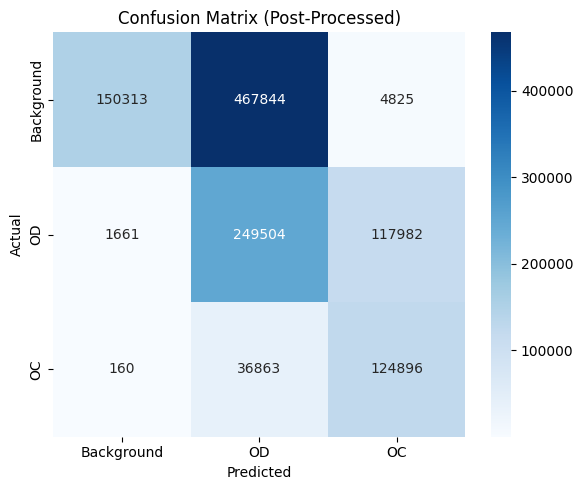

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-3-650745739.py:101: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


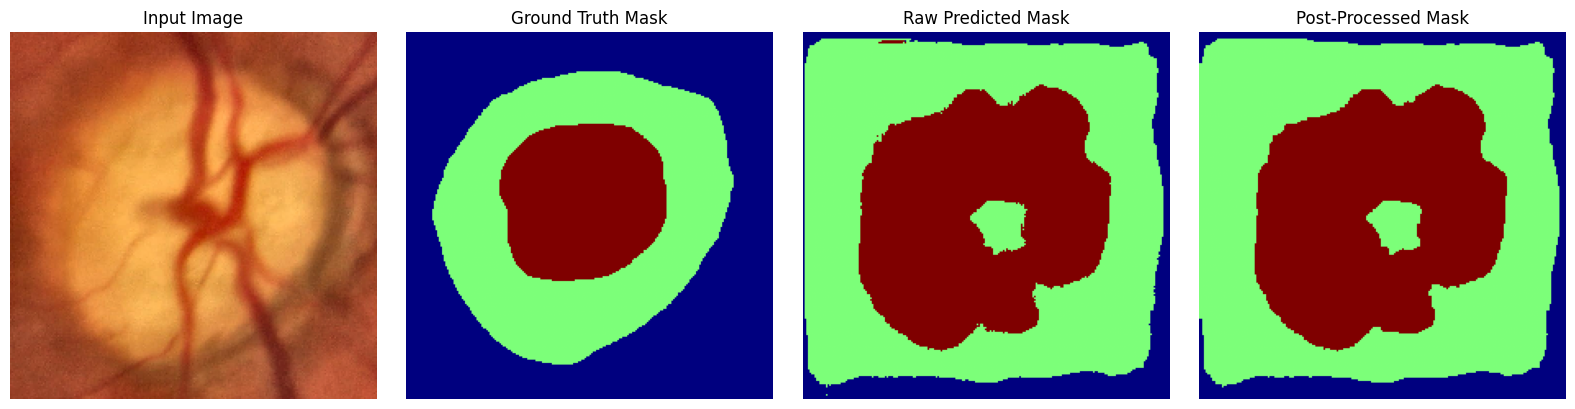

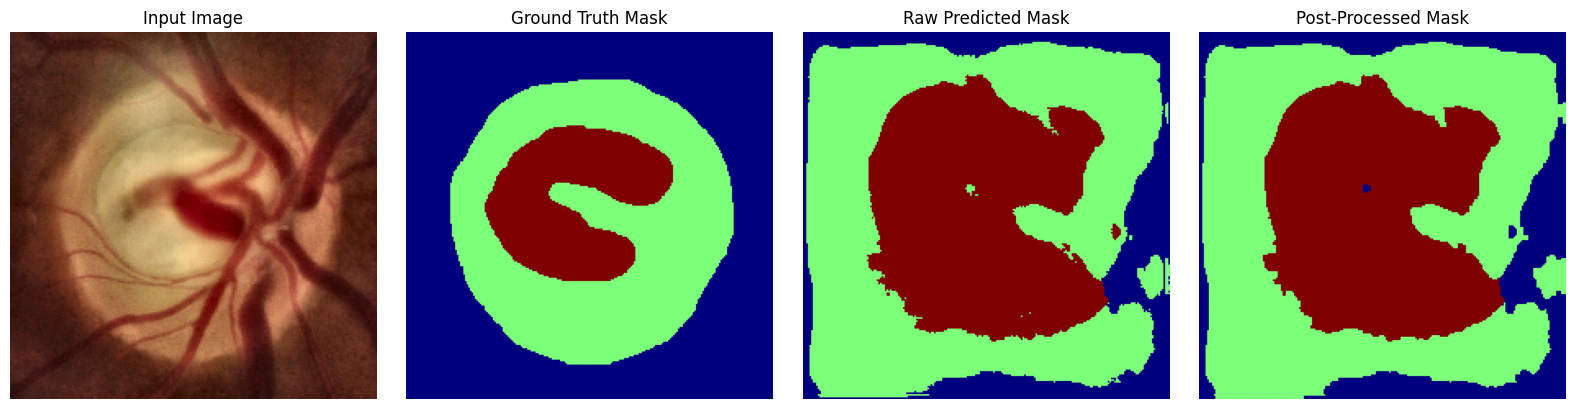

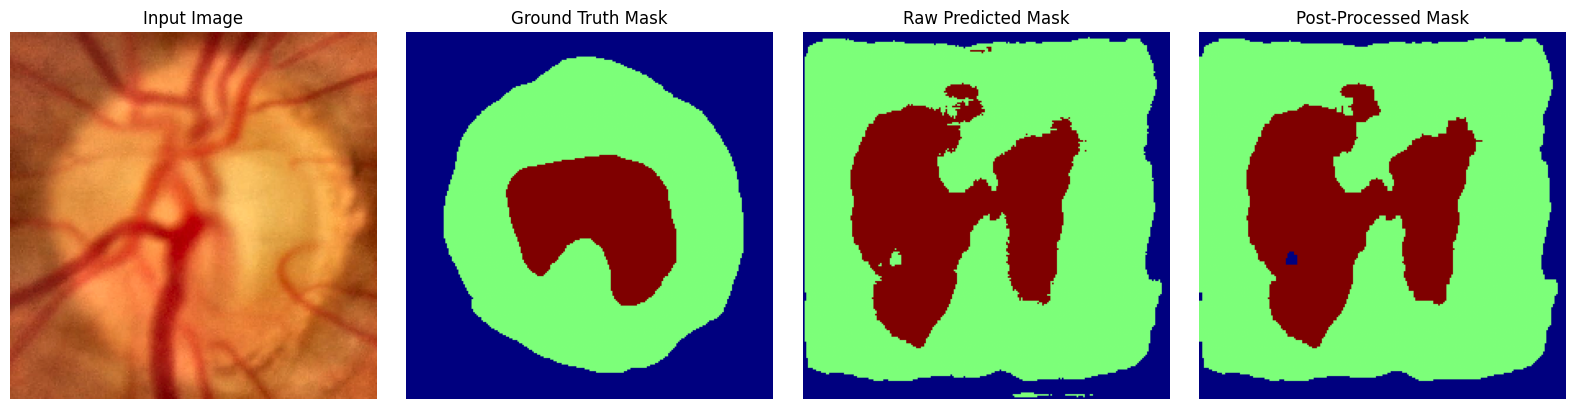

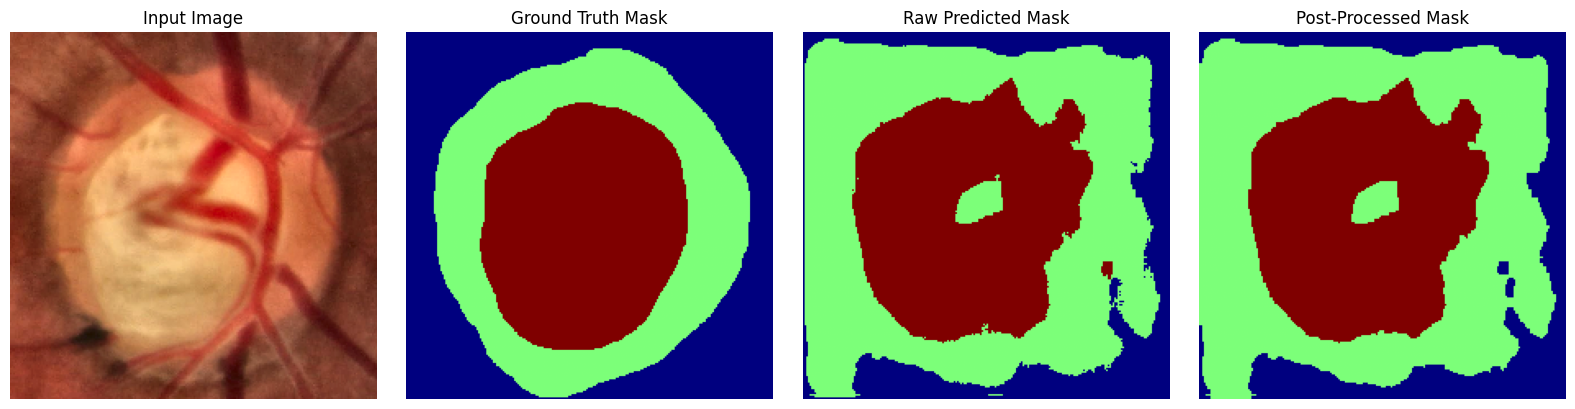

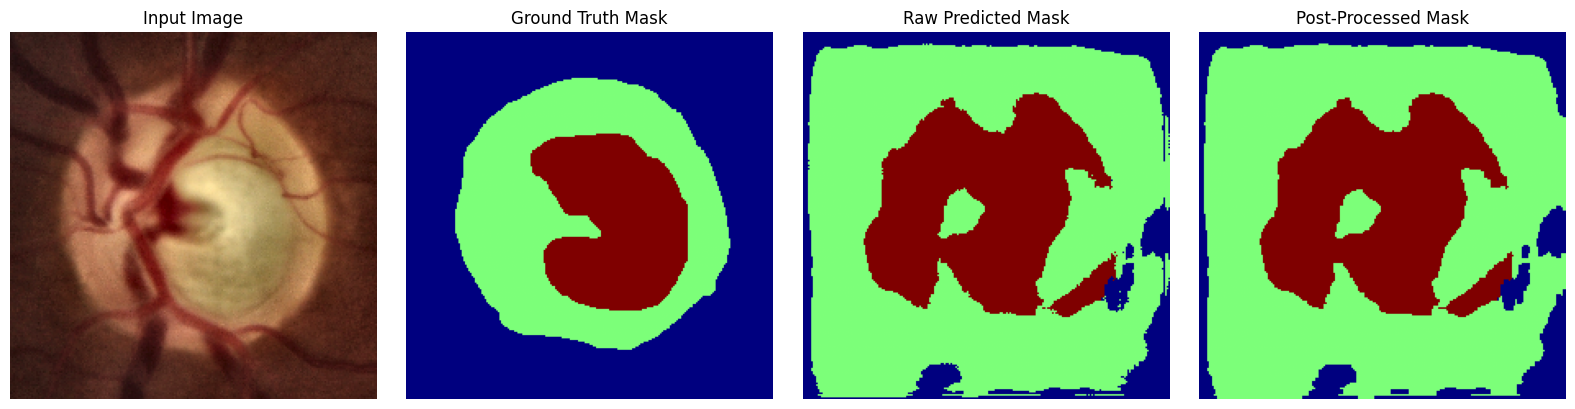

In [ ]:
# 📦 Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.morphology import closing, remove_small_objects, square
from skimage.measure import label as sk_label

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# === CONFIG ===
image_dir = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/train_g'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted/combined_masks'
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/unet_glaucoma_multiclass_retrained.h5'

IMG_SIZE = (224, 224)
NUM_CLASSES = 3

# === Load data ===
image_paths, mask_paths = [], []
for fname in os.listdir(image_dir):
    if fname.endswith('.png') and not fname.startswith('normal_'):
        img_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace('.png', '_combined.png'))
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"\u26a0\ufe0f No mask for: {fname}")

print(f"✅ Found {len(image_paths)} valid pairs.")

def load_data(image_paths, mask_paths, img_size=(224, 224), num_classes=3):
    X, Y = [], []
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Loading images"):
        img = Image.open(img_path).convert('RGB').resize(img_size)
        mask = Image.open(mask_path).convert('L').resize(img_size, resample=Image.NEAREST)

        X.append(np.array(img) / 255.0)
        Y.append(np.array(mask))

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.uint8)
    Y_cat = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    return X, Y, Y_cat

# === Prepare data ===
X, Y, Y_cat = load_data(image_paths, mask_paths)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_cat, test_size=0.2, random_state=42)
Y_val_raw = np.argmax(Y_val, axis=-1)
print(f"✅ Train: {len(X_train)} | Test: {len(X_val)}")

# === Build U-Net ===
def build_unet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    c1 = conv_block(inputs, 64); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 128); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 256); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 512); p4 = MaxPooling2D()(c4)
    c5 = conv_block(p4, 1024)

    u6 = UpSampling2D()(c5); u6 = concatenate([u6, c4]); c6 = conv_block(u6, 512)
    u7 = UpSampling2D()(c6); u7 = concatenate([u7, c3]); c7 = conv_block(u7, 256)
    u8 = UpSampling2D()(c7); u8 = concatenate([u8, c2]); c8 = conv_block(u8, 128)
    u9 = UpSampling2D()(c8); u9 = concatenate([u9, c1]); c9 = conv_block(u9, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c9)
    return Model(inputs, outputs)

# === Train model ===
model = build_unet()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=8, callbacks=[checkpoint])
print(f"✅ Model saved at: {checkpoint_path}")

# === Predict and post-process ===
Y_pred = model.predict(X_val)
Y_pred_mask = np.argmax(Y_pred, axis=-1)

def post_process_mask(pred_mask, min_size=200):
    processed = np.zeros_like(pred_mask)
    for cls in [1, 2]:
        binary = (pred_mask == cls).astype(np.uint8)
        closed = closing(binary, square(3))
        cleaned = remove_small_objects(sk_label(closed), min_size=min_size)
        processed[cleaned > 0] = cls
    return processed

Y_pred_mask_post = np.array([post_process_mask(m) for m in Y_pred_mask])

# === Evaluate ===
acc = accuracy_score(Y_val_raw.flatten(), Y_pred_mask_post.flatten())
print(f"\n🌟 Pixel-wise Accuracy (post-processed): {acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(Y_val_raw.flatten(), Y_pred_mask_post.flatten(), labels=[0, 1, 2], target_names=["Background", "OD", "OC"]))

cm = confusion_matrix(Y_val_raw.flatten(), Y_pred_mask_post.flatten(), labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "OD", "OC"], yticklabels=["Background", "OD", "OC"])
plt.title("Confusion Matrix (Post-Processed)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Visualize predictions ===
def show_predictions(model, X_val, Y_val, num=5):
    preds = model.predict(X_val[:num])
    for i in range(num):
        img = X_val[i]
        gt_mask = np.argmax(Y_val[i], axis=-1)
        raw_pred_mask = np.argmax(preds[i], axis=-1)
        post_pred_mask = post_process_mask(raw_pred_mask)

        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[1].imshow(gt_mask, cmap='jet')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(raw_pred_mask, cmap='jet')
        axs[2].set_title("Raw Predicted Mask")
        axs[3].imshow(post_pred_mask, cmap='jet')
        axs[3].set_title("Post-Processed Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Show predictions
show_predictions(model, X_val, Y_val, num=5)


In [ ]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes

# === 1. Predict raw segmentation masks ===
raw_preds = model.predict(X_val)
raw_preds_argmax = np.argmax(raw_preds, axis=-1)

# === 2. Define post-processing function ===
def post_process_mask(mask):
    final = np.zeros_like(mask)
    for cls in [1, 2]:  # Process only OD (1) and OC (2)
        binary = (mask == cls).astype(np.uint8)
        binary = binary_opening(binary, structure=np.ones((3, 3)))
        binary = binary_closing(binary, structure=np.ones((3, 3)))
        binary = binary_fill_holes(binary)
        final[binary == 1] = cls
    return final

# === 3. Apply post-processing to predictions ===
post_processed_preds = [post_process_mask(m) for m in raw_preds_argmax]

# === 4. Save the post-processed masks ===
save_dir = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/post_processed_masks"
os.makedirs(save_dir, exist_ok=True)

for i, mask in enumerate(post_processed_preds):
    filename = os.path.basename(image_paths[i])
    save_path = os.path.join(save_dir, filename.replace('.png', '_pred.png'))
    Image.fromarray(mask.astype(np.uint8)).save(save_path)

print("✅ All post-processed masks saved to:", save_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
✅ All post-processed masks saved to: /content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/post_processed_masks


In [ ]:
q

100%|██████████| 23/23 [00:00<00:00, 300.27it/s]

✅ Final predictions saved to: /content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv
✅ Saved rule-based severity model to: /content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl


🧾 Columns in Prediction CSV: ['filename', 'disc_area', 'cup_area', 'cdr_percent', 'severity']
🧾 Columns in Ground Truth CSV: ['filename', 'optic_disc_area', 'optic_cup_area', 'cdr', 'cdr_percent', 'predicted_severity']

✅ Merged rows: 23
🎯 Unique true labels: ['Mild', 'Severe', 'Moderate']
🎯 Unique predicted labels: ['Moderate', 'Mild']

📋 Classification Report:
              precision    recall  f1-score   support

        Mild     0.6111    0.6875    0.6471        16
    Moderate     0.0000    0.0000    0.0000         2
      Severe     0.0000    0.0000    0.0000         5

    accuracy                         0.4783        23
   macro avg     0.2037    0.2292    0.2157        23
weighted avg     0.4251    0.4783    0.4501        23



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


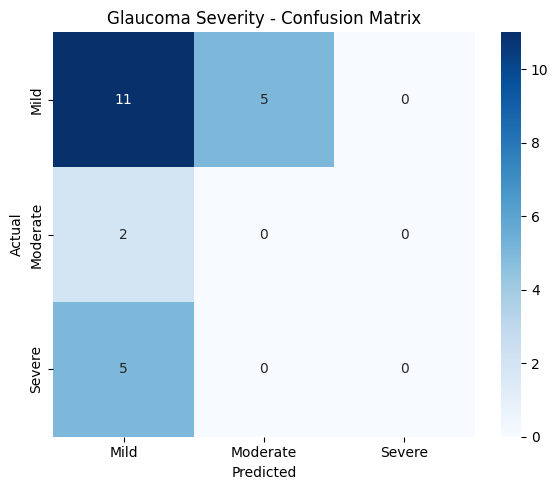

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# === File Paths ===
PRED_CSV = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv"
GT_CSV   = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/ground_truth_severity.csv"  # ← Update if needed

# === Load data
df_pred = pd.read_csv(PRED_CSV)
df_gt = pd.read_csv(GT_CSV)

print("🧾 Columns in Prediction CSV:", df_pred.columns.tolist())
print("🧾 Columns in Ground Truth CSV:", df_gt.columns.tolist())

# === Clean filename (remove _pred, lowercase for consistency)
df_pred['filename'] = df_pred['filename'].apply(lambda x: os.path.basename(x).replace('_pred', '').lower())
df_gt['filename'] = df_gt['filename'].apply(lambda x: os.path.basename(x).lower())

# === Rename ground truth severity column if needed
if 'predicted_severity' in df_gt.columns:
    df_gt = df_gt.rename(columns={'predicted_severity': 'true_severity'})
elif 'severity' in df_gt.columns:
    df_gt = df_gt.rename(columns={'severity': 'true_severity'})

# === Merge predictions with ground truth
df = pd.merge(df_pred, df_gt[['filename', 'true_severity']], on='filename', how='inner')
print(f"\n✅ Merged rows: {len(df)}")
print(f"🎯 Unique true labels: {df['true_severity'].unique().tolist()}")
print(f"🎯 Unique predicted labels: {df['severity'].unique().tolist()}")

# === Classification Report
print("\n📋 Classification Report:")
print(classification_report(df["true_severity"], df["severity"], digits=4))

# === Confusion Matrix
cm = confusion_matrix(df["true_severity"], df["severity"], labels=["Mild", "Moderate", "Severe"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Mild", "Moderate", "Severe"],
            yticklabels=["Mild", "Moderate", "Severe"])
plt.title("Glaucoma Severity - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
!pip install joblib


Saving r3_G-23-R_left_half.png to r3_G-23-R_left_half.png


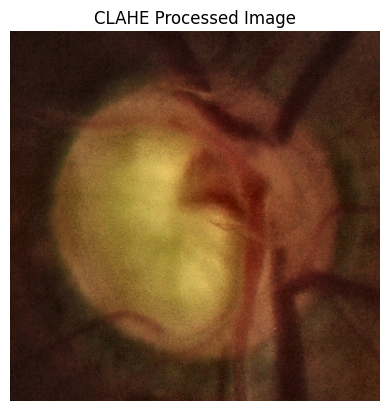

In [ ]:
from google.colab import files
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# === STEP 1: User Upload ===
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]

# === STEP 2: CLAHE Enhancement ===
def clahe_enhance(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"❌ Cannot read image from: {img_path}")
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced_img

# === STEP 3: Display Image
def display_image(title, img):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# === APPLY CLAHE and DISPLAY
try:
    processed_img = clahe_enhance(input_image_path)
    display_image("CLAHE Processed Image", processed_img)
except Exception as e:
    print("⚠️ Error:", e)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import tensorflow as tf
import joblib
import pandas as pd
from tensorflow.keras.models import load_model

# === Load Models ===
clf_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5'
seg_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_segmentation.h5'
severity_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl'

clf_model = load_model(clf_model_path)
seg_model = load_model(seg_model_path)
severity_model = joblib.load(severity_model_path)  # This is a custom rule-based class

IMG_SIZE = (224, 224)

# === Step 1: Upload Image ===
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]
print("✅ Image uploaded:", input_image_path)

# === Step 2: CLAHE Preprocessing ===
def clahe_enhance(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"❌ Cannot read image from: {img_path}")
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced_img

def display_image(title, img):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Apply CLAHE
clahe_img = clahe_enhance(input_image_path)
display_image("CLAHE Processed Image", clahe_img)

# === Step 3: Glaucoma Classification ===
def predict_glaucoma(image_rgb):
    img_resized = cv2.resize(image_rgb, IMG_SIZE)
    img_input = np.expand_dims(img_resized / 255.0, axis=0)
    pred = clf_model.predict(img_input)[0][0]
    return "Glaucoma" if pred > 0.5 else "Healthy"

result = predict_glaucoma(clahe_img)
print(f"\n🧠 Glaucoma Classification Result: **{result}**")

# === Step 4: If Glaucoma → Segmentation + Feature Extraction ===
if result == "Glaucoma":
    print("\n🔍 Running Segmentation and Severity Analysis...")

    # Prepare input
    img_input = np.expand_dims(cv2.resize(clahe_img, IMG_SIZE) / 255.0, axis=0)

    # Predict segmentation mask
    pred_mask = seg_model.predict(img_input)[0]
    mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)

    # Show mask with color
    cmap = np.zeros((*mask.shape, 3), dtype=np.uint8)
    cmap[mask == 1] = [255, 255, 0]  # OD = Yellow
    cmap[mask == 2] = [255, 0, 0]    # OC = Red
    display_image("Segmentation Mask", cmap)

    # === Step 5: Feature Extraction
    disc_area = np.sum(mask == 1)
    cup_area = np.sum(mask == 2)
    cdr = min((cup_area / disc_area) * 100, 100.0) if disc_area > 0 else 0.0

    # === Step 6: Severity Prediction using custom rule-based model
    severity = severity_model.predict(disc_area, cup_area) if disc_area > 0 else "Unknown"

    # === Output Results
    print(f"\n📊 Extracted Features:")
    print(f" - Disc Area : {disc_area}")
    print(f" - Cup Area  : {cup_area}")
    print(f" - CDR %     : {round(cdr, 2)}%")
    print(f" - 🔥 Severity: {severity}")

else:
    print("\n✅ Image is classified as Healthy. No further processing required.")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import gradio as gr
import numpy as np
import cv2
import os
import tensorflow as tf
import joblib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === Load Models ===
clf_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5'
seg_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_segmentation.h5'
severity_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl'

clf_model = load_model(clf_model_path)
seg_model = load_model(seg_model_path)
severity_model = joblib.load(severity_model_path)

IMG_SIZE = (224, 224)

# === CLAHE Preprocessing ===
def clahe_enhance(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced_img

# === Prediction Pipeline ===
def glaucoma_pipeline(input_img):
    # Step 1: CLAHE
    clahe_img = clahe_enhance(np.array(input_img))

    # Step 2: Classification
    img_resized = cv2.resize(clahe_img, IMG_SIZE)
    img_input = np.expand_dims(img_resized / 255.0, axis=0)
    pred = clf_model.predict(img_input)[0][0]
    label = "Glaucoma" if pred > 0.5 else "Healthy"

    if label == "Healthy":
        return (
            Image.fromarray(clahe_img),
            label,
            None,
            None,
            None,
            None,
            None
        )

    # Step 3: Segmentation
    seg_pred = seg_model.predict(img_input)[0]
    mask = np.argmax(seg_pred, axis=-1).astype(np.uint8)

    # Create color mask
    cmap = np.zeros((*mask.shape, 3), dtype=np.uint8)
    cmap[mask == 1] = [255, 255, 0]  # OD
    cmap[mask == 2] = [255, 0, 0]    # OC

    # Step 4: Feature Extraction
    disc_area = int(np.sum(mask == 1))
    cup_area = int(np.sum(mask == 2))
    cdr_percent = round(min((cup_area / disc_area) * 100, 100.0), 2) if disc_area > 0 else 0.0

    # Step 5: Severity
    severity = (
        severity_model.predict([[disc_area, cup_area]])[0]
        if disc_area > 0 else "Unknown"
    )

    return (
        Image.fromarray(clahe_img),
        label,
        Image.fromarray(cmap),
        disc_area,
        cup_area,
        cdr_percent,
        severity
    )

# === Gradio Interface ===
interface = gr.Interface(
    fn=glaucoma_pipeline,
    inputs=gr.Image(type="numpy", label="Upload Fundus Image"),
    outputs=[
        gr.Image(type="pil", label="CLAHE Processed Image"),
        gr.Textbox(label="Prediction (Healthy / Glaucoma)"),
        gr.Image(type="pil", label="Segmentation (OD & OC)", visible=True),
        gr.Number(label="Disc Area", visible=True),
        gr.Number(label="Cup Area", visible=True),
        gr.Number(label="CDR %", visible=True),
        gr.Textbox(label="Severity", visible=True),
    ],
    title="🧠 Glaucoma Detection and Severity Estimation",
    description="Upload a fundus image to detect glaucoma. If glaucoma is found, the system will segment the optic disc and cup, calculate the CDR, and predict the severity."
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ffbfdf68d4ceffa45.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ffbfdf68d4ceffa45.gradio.live


In [ ]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
import joblib
from PIL import Image
from tensorflow.keras.models import load_model

# === Load Models ===
clf_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5'
seg_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_segmentation.h5'
severity_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl'

IMG_SIZE = (224, 224)

# === CLAHE ===
def clahe_enhance(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# === Step 1: Classification Page ===
def classify_image(input_img):
    clahe_img = clahe_enhance(np.array(input_img))
    img_resized = cv2.resize(clahe_img, IMG_SIZE)
    input_arr = np.expand_dims(img_resized / 255.0, axis=0)
    pred = clf_model.predict(input_arr)[0][0]
    label = "Glaucoma" if pred > 0.5 else "Healthy"
    return (
        Image.fromarray(clahe_img),
        label,
        clahe_img if label == "Glaucoma" else None
    )

# === Step 2: Segmentation + Severity Page ===
def analyze_severity(clahe_img):
    img_input = np.expand_dims(cv2.resize(clahe_img, IMG_SIZE) / 255.0, axis=0)
    pred_mask = seg_model.predict(img_input)[0]
    mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)

    cmap = np.zeros((*mask.shape, 3), dtype=np.uint8)
    cmap[mask == 1] = [255, 255, 0]
    cmap[mask == 2] = [255, 0, 0]

    disc_area = int(np.sum(mask == 1))
    cup_area = int(np.sum(mask == 2))
    cdr_percent = round(min((cup_area / disc_area) * 100, 100.0), 2) if disc_area > 0 else 0.0
    severity = severity_model.predict([[disc_area, cup_area]])[0] if disc_area > 0 else "Unknown"

    return (
        Image.fromarray(cmap),
        disc_area,
        cup_area,
        cdr_percent,
        severity
    )

# === Interface ===
with gr.Blocks() as demo:
    with gr.Tab("1️⃣ Classification"):
        image_input = gr.Image(type="numpy", label="Upload Fundus Image")
        clahe_out = gr.Image(type="pil", label="CLAHE Processed")
        label_out = gr.Textbox(label="Prediction Result")
        hidden_clahe = gr.State()

        classify_btn = gr.Button("Classify")
        classify_btn.click(fn=classify_image, inputs=image_input, outputs=[clahe_out, label_out, hidden_clahe])

    with gr.Tab("2️⃣ Segmentation + Severity (Only if Glaucoma)"):
        clahe_in_seg = gr.State()
        seg_out = gr.Image(type="pil", label="Segmentation")
        disc_out = gr.Number(label="Disc Area")
        cup_out = gr.Number(label="Cup Area")
        cdr_out = gr.Number(label="CDR %")
        severity_out = gr.Textbox(label="Severity")

        analyze_btn = gr.Button("Run Segmentation + Severity")
        analyze_btn.click(fn=analyze_severity, inputs=hidden_clahe, outputs=[seg_out, disc_out, cup_out, cdr_out, severity_out])

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4bb18c2febb438f9e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2235, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1746, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4bb18c2febb438f9e3.gradio.live


⚠️ No mask for: r3_S-31-L_left_half.png
⚠️ No mask for: r2_Im454.png
✅ Found 114 valid pairs.


Loading images: 100%|██████████| 114/114 [01:34<00:00,  1.21it/s]


✅ Train: 91 | Test: 23
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5521 - loss: 1.0969   

12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.5598 - loss: 1.0789 - val_accuracy: 0.5439 - val_loss: 1.0573
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7991 - loss: 0.5248

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 690ms/step - accuracy: 0.7992 - loss: 0.5242 - val_accuracy: 0.5398 - val_loss: 1.0149
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.8405 - loss: 0.3988 - val_accuracy: 0.5398 - val_loss: 1.0163
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.8572 - loss: 0.3739 - val_accuracy: 0.5398 - val_loss: 1.0446
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.8705 - loss: 0.3166 - val_accuracy: 0.5398 - val_loss: 1.0172
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8829 - loss: 0.2950

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.8823 - loss: 0.2967 - val_accuracy: 0.5398 - val_loss: 0.9127
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.8959 - loss: 0.2580 - val_accuracy: 0.5398 - val_loss: 0.9175
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9066 - loss: 0.2398

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9063 - loss: 0.2406 - val_accuracy: 0.5398 - val_loss: 0.8472
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - accuracy: 0.9169 - loss: 0.2072 - val_accuracy: 0.5398 - val_loss: 1.1637
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.9207 - loss: 0.1965 - val_accuracy: 0.5398 - val_loss: 0.8574
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9323 - loss: 0.1701

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 629ms/step - accuracy: 0.9321 - loss: 0.1704 - val_accuracy: 0.5580 - val_loss: 0.7841
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - accuracy: 0.9319 - loss: 0.1704 - val_accuracy: 0.6532 - val_loss: 0.8435
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.9369 - loss: 0.1569 - val_accuracy: 0.5414 - val_loss: 0.8735
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - accuracy: 0.9411 - loss: 0.1480 - val_accuracy: 0.5398 - val_loss: 0.9696
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9169 - loss: 0.2078

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step - accuracy: 0.9167 - loss: 0.2082 - val_accuracy: 0.7342 - val_loss: 0.5878
Epoch 16/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9127 - loss: 0.2113

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 804ms/step - accuracy: 0.9123 - loss: 0.2126 - val_accuracy: 0.7561 - val_loss: 0.5708
Epoch 17/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.9305 - loss: 0.1735 - val_accuracy: 0.7357 - val_loss: 0.7395
Epoch 18/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.9279 - loss: 0.1843 - val_accuracy: 0.5972 - val_loss: 0.8930
Epoch 19/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.9475 - loss: 0.1279 - val_accuracy: 0.6350 - val_loss: 0.9128
Epoch 20/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.9502 - loss: 0.1215 - val_accuracy: 0.7504 - val_loss: 0.6100
Epoch 21/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.9551 - loss: 0.1109 - val_accuracy: 0.5761 - val_loss: 1.0772
Epoch 22/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.9616 - loss: 0.0959 - val_accuracy: 0.5240 - val_loss: 1.4200
Epoch 23/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 506ms/step - accuracy: 0.9615 - loss: 0.0954 - val_accuracy: 0

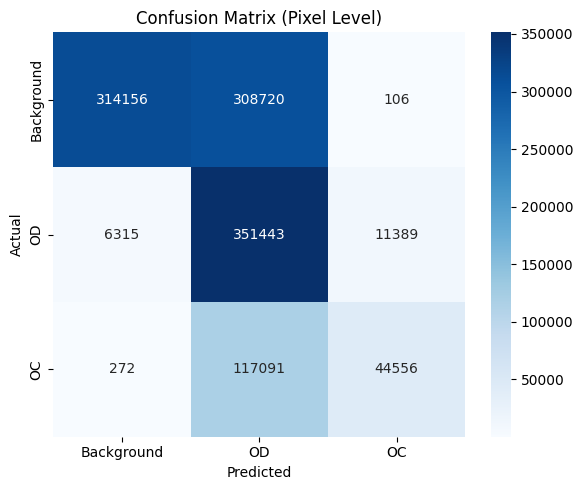

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


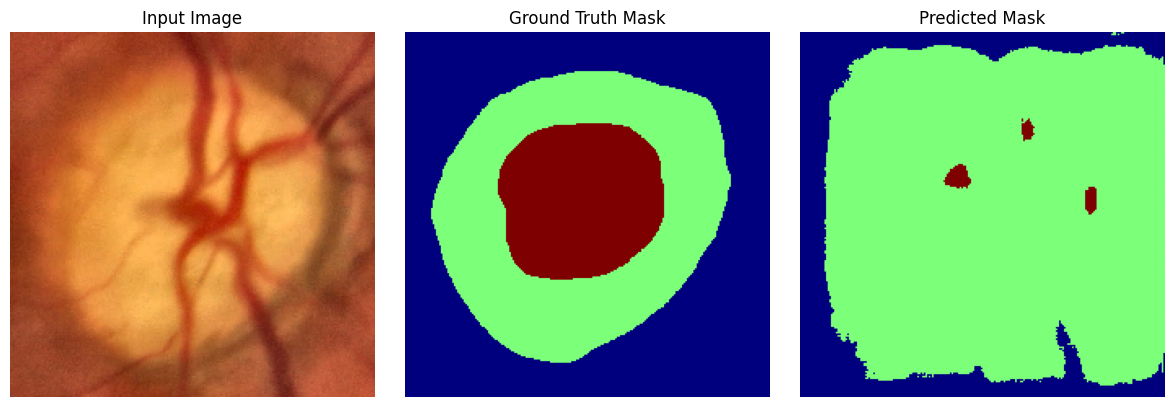

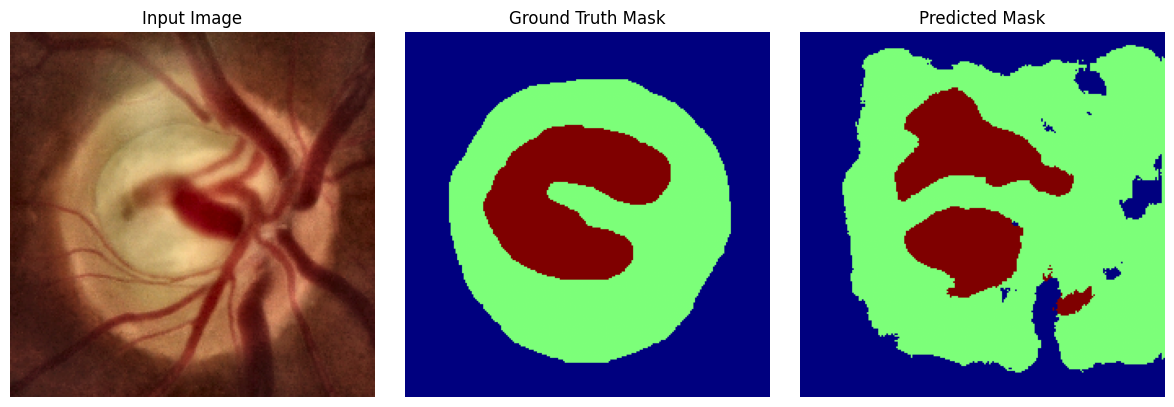

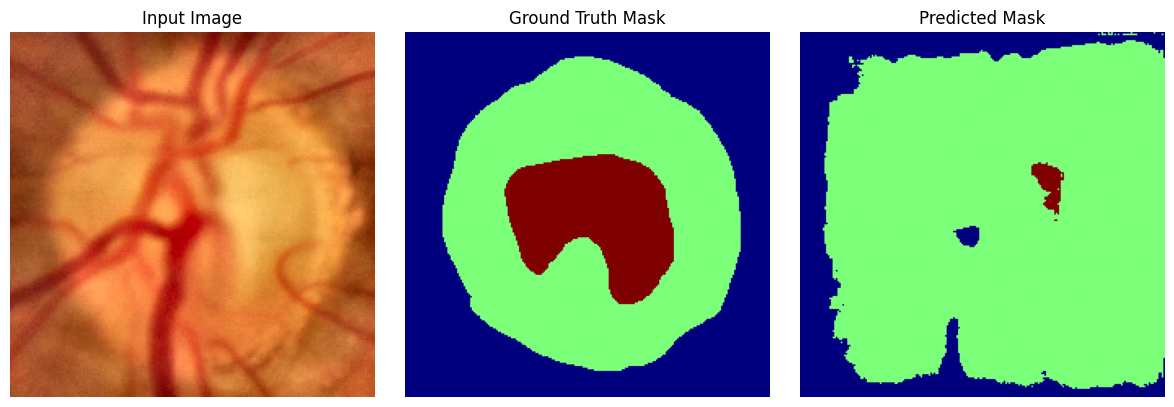

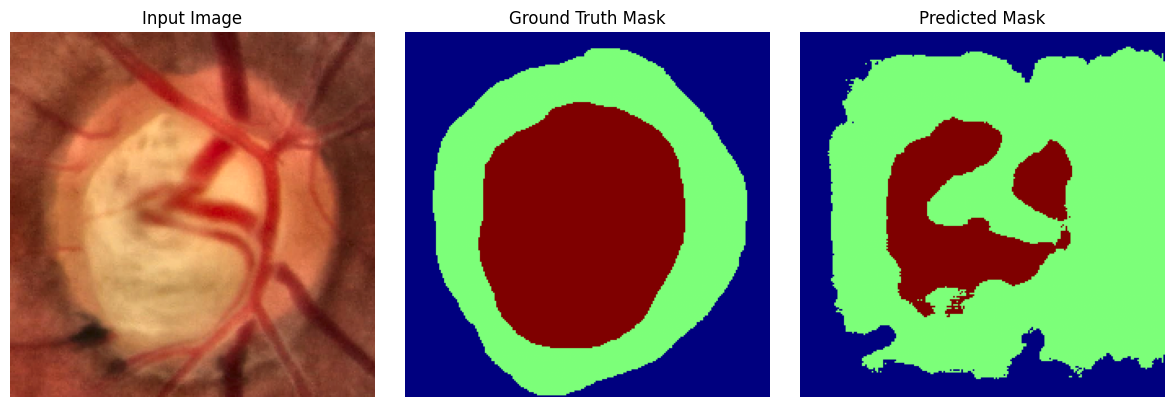

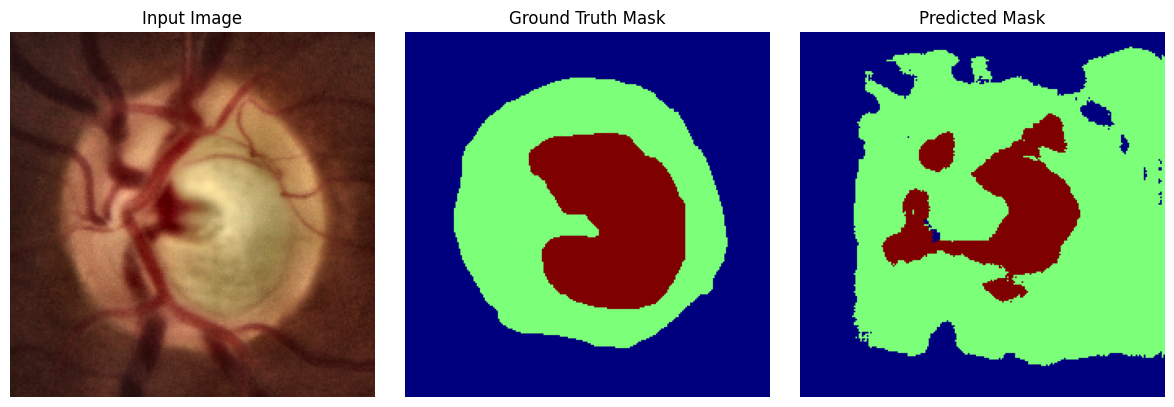

In [ ]:
# 📦 Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# === CONFIG ===
image_dir = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/train_g'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_converted/combined_masks'
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/unet_glaucoma_multiclass_retrained.h5'

IMG_SIZE = (224, 224)
NUM_CLASSES = 3

# === Load Data Paths
image_paths, mask_paths = [], []
for fname in os.listdir(image_dir):
    if fname.endswith('.png') and not fname.startswith('normal_'):
        img_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace('.png', '_combined.png'))
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"⚠️ No mask for: {fname}")

print(f"✅ Found {len(image_paths)} valid pairs.")

# === Data Loader
def load_data(image_paths, mask_paths, img_size=(224, 224), num_classes=3):
    X, Y = [], []
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Loading images"):
        img = Image.open(img_path).convert('RGB').resize(img_size)
        mask = Image.open(mask_path).convert('L').resize(img_size, resample=Image.NEAREST)

        X.append(np.array(img) / 255.0)
        Y.append(np.array(mask))

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.uint8)
    Y_cat = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    return X, Y, Y_cat

# === Prepare Data
X, Y, Y_cat = load_data(image_paths, mask_paths)
X_train, X_val, Y_train, Y_val, Y_train_true, Y_val_true = train_test_split(
    X, Y_cat, Y, test_size=0.2, random_state=42
)
print(f"✅ Train: {len(X_train)} | Test: {len(X_val)}")

# === Build U-Net
def build_unet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    c1 = conv_block(inputs, 64); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 128); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 256); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 512); p4 = MaxPooling2D()(c4)
    c5 = conv_block(p4, 1024)

    u6 = UpSampling2D()(c5); u6 = concatenate([u6, c4]); c6 = conv_block(u6, 512)
    u7 = UpSampling2D()(c6); u7 = concatenate([u7, c3]); c7 = conv_block(u7, 256)
    u8 = UpSampling2D()(c7); u8 = concatenate([u8, c2]); c8 = conv_block(u8, 128)
    u9 = UpSampling2D()(c8); u9 = concatenate([u9, c1]); c9 = conv_block(u9, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c9)
    return Model(inputs, outputs)

# === Compile & Train
model = build_unet()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8,
    callbacks=[checkpoint]
)

print(f"✅ Model saved at: {checkpoint_path}")

# === Evaluate Model
Y_pred = model.predict(X_val)
Y_pred_mask = np.argmax(Y_pred, axis=-1).flatten()
Y_true_mask = Y_val_true.flatten()

acc = accuracy_score(Y_true_mask, Y_pred_mask)
print(f"\n🎯 Pixel-wise Accuracy: {acc:.4f}")
print("\n📋 Classification Report:")
print(classification_report(Y_true_mask, Y_pred_mask, labels=[0, 1, 2], target_names=["Background", "OD", "OC"]))

# === Confusion Matrix
cm = confusion_matrix(Y_true_mask, Y_pred_mask, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "OD", "OC"], yticklabels=["Background", "OD", "OC"])
plt.title("Confusion Matrix (Pixel Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Visualization
def show_predictions(model, X_val, Y_val, num=5):
    preds = model.predict(X_val[:num])
    for i in range(num):
        img = X_val[i]
        gt_mask = np.argmax(Y_val[i], axis=-1)
        pred_mask = np.argmax(preds[i], axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[1].imshow(gt_mask, cmap='jet')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred_mask, cmap='jet')
        axs[2].set_title("Predicted Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

show_predictions(model, X_val, Y_val, num=5)


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# === Define your paths here ===
image_dir = '/content/drive/MyDrive/Colab Notebooks/glaucoma_d_&_c(hospital)/data/processed/train'
mask_dir = '/content/drive/MyDrive/glaucoma_d_&_c(hospital)/data/segmentation_masks/combined_masks_OG'

# === Collect valid image-mask pairs ===
image_paths, valid_masks = [], []

for filename in os.listdir(image_dir):
    if filename.endswith(".png") and not filename.startswith("normal_"):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            valid_masks.append(mask_path)

# === Image size ===
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 3  # background=0, OD=1, OC=2

# === Load Images and Masks ===
def load_data(image_paths, mask_paths, img_size=(224, 224), num_classes=3):
    X, Y = [], []
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        img = Image.open(img_path).convert('RGB').resize(img_size)
        mask = Image.open(mask_path).convert('L').resize(img_size, resample=Image.NEAREST)

        X.append(np.array(img) / 255.0)
        Y.append(np.array(mask))  # Keep 0, 1, 2 intact

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.uint8)
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)  # One-hot
    return X, Y

# === Load and split data ===
X, Y = load_data(image_paths, valid_masks)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# === U-Net model ===
def build_unet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    c1 = conv_block(inputs, 64); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 128); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 256); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 512); p4 = MaxPooling2D()(c4)

    c5 = conv_block(p4, 1024)

    u6 = UpSampling2D()(c5); u6 = concatenate([u6, c4]); c6 = conv_block(u6, 512)
    u7 = UpSampling2D()(c6); u7 = concatenate([u7, c3]); c7 = conv_block(u7, 256)
    u8 = UpSampling2D()(c7); u8 = concatenate([u8, c2]); c8 = conv_block(u8, 128)
    u9 = UpSampling2D()(c8); u9 = concatenate([u9, c1]); c9 = conv_block(u9, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c9)
    return Model(inputs, outputs)

# === Compile & Train ===
model = build_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = '/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_multiclass.h5'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=8,
    callbacks=[checkpoint]
)

print(f"✅ Model saved to: {checkpoint_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/glaucoma_d_&_c(hospital)/data/processed/train'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# === Load the trained model
#model_path = '/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_multiclass.h5'
model_path ='/content/drive/MyDrive/Colab Notebooks/glaucoma_d_&_c(hospital)/unet_glaucoma_segmentation.h5'
model = load_model(model_path)

# === Visualize predictions
def show_predictions(model, X_val, Y_val, num=5):
    preds = model.predict(X_val[:num])
    for i in range(num):
        img = X_val[i]
        gt_mask = np.argmax(Y_val[i], axis=-1)
        pred_mask = np.argmax(preds[i], axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[1].imshow(gt_mask, cmap='jet')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred_mask, cmap='jet')
        axs[2].set_title("Predicted Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# 🔍 Run predictions
show_predictions(model, X_val, Y_val, num=5)


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Paths ===
MODEL_PATH = '/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_multiclass.h5'
TEST_IMG_DIR = '/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/test'
SAVE_MASK_DIR = '/content/drive/MyDrive/NEW PIPELINE/partitioned_by_hospital/Output/predicted_masks'
IMG_SIZE = (224, 224)

# Create output folder if it doesn't exist
os.makedirs(SAVE_MASK_DIR, exist_ok=True)

# === Load model ===
model = tf.keras.models.load_model(MODEL_PATH)

# === Predict and save masks ===
def predict_and_save_masks(model, test_dir, save_dir, img_size):
    for fname in tqdm(os.listdir(test_dir)):
        if not fname.endswith(".png"):
            continue

        img_path = os.path.join(test_dir, fname)
        img = Image.open(img_path).convert('RGB').resize(img_size)
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalize and batch

        pred = model.predict(img_array)[0]
        pred_mask = np.argmax(pred, axis=-1).astype(np.uint8)

        # Save as PNG
        save_path = os.path.join(save_dir, fname)
        Image.fromarray(pred_mask).save(save_path)

        # Optional: also save color visualization (for debugging)
        # cmap = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        # cmap[pred_mask == 1] = [255, 255, 0]   # Yellow for OD
        # cmap[pred_mask == 2] = [255, 0, 0]     # Red for OC
        # Image.fromarray(cmap).save(save_path.replace(".png", "_color.png"))

    print("✅ Done predicting and saving masks.")

predict_and_save_masks(model, TEST_IMG_DIR, SAVE_MASK_DIR, IMG_SIZE)


In [ ]:
import pandas as pd

# 📥 Load previously extracted features
input_csv = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_feature_with_severity.csv"
 # Update if needed
df = pd.read_csv(input_csv)

# ✅ Correct and clip CDR percent
def compute_cdr_and_severity(row):
    disc = row["disc_area"]
    cup = row["cup_area"]

    if disc == 0:
        return pd.Series({"cdr_percent": 0.0, "severity": None})

    # Raw CDR percent
    cdr = (cup / disc) * 100

    # Clip to 100 if overflow
    cdr = min(cdr, 100.0)

    # Classify severity
    if cdr < 50:
        severity = "Mild"
    elif 50 <= cdr < 80:
        severity = "Moderate"
    else:
        severity = "Severe"

    return pd.Series({"cdr_percent": round(cdr, 2), "severity": severity})

# 🧠 Apply correction and severity classification
df[["cdr_percent", "severity"]] = df.apply(compute_cdr_and_severity, axis=1)

# 💾 Save updated predictions
output_csv = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv"
df.to_csv(output_csv, index=False)

print("✅ Final predictions saved to:", output_csv)


In [ ]:
import pandas as pd

# Load your actual CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/glaucoma_d_&_c(hospital)/features/train_segmentation_features.csv")  # already uploaded

# Rule-based severity prediction using correct column names
def classify_severity(row):
    disc = row["optic_disc_area"]
    cup = row["optic_cup_area"]

    if disc == 0:
        return pd.Series({"cdr_percent": 0.0, "severity": None})

    cdr_percent = (cup / disc) * 100
    cdr_percent = min(cdr_percent, 100.0)

    if cdr_percent < 50:
        severity = "Mild"
    elif 50 <= cdr_percent < 80:
        severity = "Moderate"
    else:
        severity = "Severe"

    return pd.Series({"cdr_percent": round(cdr_percent, 2), "severity": severity})

# Apply the rule to all rows
df[["cdr_percent", "severity"]] = df.apply(classify_severity, axis=1)

# Save to a new CSV
output_path = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/train_features_with_severity.csv"
df.to_csv(output_path, index=False)

print("✅ Severity prediction complete. Saved to:", output_path)


In [ ]:
import pandas as pd
import joblib

# 📥 Load extracted CDR features
csv_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv'
df = pd.read_csv(csv_path)

print("📌 Available columns:", df.columns.tolist())

# 🧠 Rule-based classifier using cdr_percent
def classify_severity(cdr_percent):
    if cdr_percent < 50:
        return "Mild"
    elif 50 <= cdr_percent < 80:
        return "Moderate"
    else:
        return "Severe"

# 🔁 Apply rule
df['severity'] = df['cdr_percent'].apply(classify_severity)

# 💾 Save new CSV with severity
output_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/severity_predictions.csv'
df.to_csv(output_path, index=False)
print(f"✅ Saved final severity predictions to: {output_path}")

# 💾 Save rule as callable class (optional model)
class SeverityClassifier:
    def predict(self, cdr_percent):
        if cdr_percent < 50:
            return "Mild"
        elif 50 <= cdr_percent < 80:
            return "Moderate"
        else:
            return "Severe"

# Save model object
model = SeverityClassifier()
model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Saved rule-based severity model to: {model_path}")


In [ ]:
import joblib

# 🔁 Load the rule-based model
model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/severity_rule_model.pkl'
severity_model = joblib.load(model_path)

# 🔮 Example prediction
cdr_example = 68.5  # Replace with any real CDR percent
severity = severity_model.predict(cdr_example)
print(f"Predicted Severity: {severity}")


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === CONFIG ===
IMG_SIZE = (224, 224)
CLASSIFIER_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/glaucoma_cnn_balanced.h5"
SEGMENTATION_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_multiclass.h5"
TEST_IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/test_set"
FINAL_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv"

# === LOAD MODELS ===
classifier_model = load_model(CLASSIFIER_MODEL_PATH)
segment_model = load_model(SEGMENTATION_MODEL_PATH)

# === CLASSIFY IMAGE ===
def predict_label(image_path, model, img_size=IMG_SIZE):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)[0][0]
    return "Glaucoma" if pred > 0.5 else "Healthy"

# === SEGMENTATION ===
def segment_image(image_path, model, img_size=IMG_SIZE):
    img = Image.open(image_path).convert("RGB").resize(img_size)
    img_np = np.array(img) / 255.0
    input_tensor = np.expand_dims(img_np, axis=0)
    pred_mask = model.predict(input_tensor, verbose=0)[0]
    mask = np.argmax(pred_mask, axis=-1)
    return mask.astype(np.uint8)

# === FEATURE EXTRACTION ===
def extract_cdr_features(mask, disc_class=1, cup_class=2):
    disc_mask = (mask == disc_class)
    cup_mask = (mask == cup_class)
    disc_area = np.sum(disc_mask)
    cup_area = np.sum(cup_mask)

    # Avoid division by zero
    if disc_area == 0:
        return 0, 0, 0.0

    cdr_area = (cup_area / disc_area) * 100
    cdr_area = min(cdr_area, 100.0)  # Clip to 100

    def vertical_extent(binary_mask):
        ys = np.where(binary_mask)[0]
        return ys.max() - ys.min() + 1 if ys.size > 0 else 0

    od_height = vertical_extent(disc_mask)
    oc_height = vertical_extent(cup_mask)

    # Not used for severity, but returned for completeness
    cdr_vertical = (oc_height / od_height) * 100 if od_height else 0.0

    return disc_area, cup_area, round(cdr_area, 2)

# === SEVERITY RULE ===
def classify_severity(cdr_percent):
    if cdr_percent < 50:
        return "Mild"
    elif 50 <= cdr_percent < 80:
        return "Moderate"
    else:
        return "Severe"

# === MAIN LOOP ===
results = []

for filename in tqdm(os.listdir(TEST_IMAGE_DIR), desc="🔍 Processing Images"):
    if not filename.lower().endswith(".png"):
        continue

    img_path = os.path.join(TEST_IMAGE_DIR, filename)
    label = predict_label(img_path, classifier_model)

    if label == "Healthy":
        results.append({
            "filename": filename,
            "prediction": label,
            "disc_area": 0,
            "cup_area": 0,
            "cdr_percent": 0.0,
            "severity": None
        })
    else:
        mask = segment_image(img_path, segment_model)
        disc_area, cup_area, cdr_percent = extract_cdr_features(mask)
        severity = classify_severity(cdr_percent)

        results.append({
            "filename": filename,
            "prediction": label,
            "disc_area": disc_area,
            "cup_area": cup_area,
            "cdr_percent": cdr_percent,
            "severity": severity
        })

# === SAVE TO CSV ===
df_results = pd.DataFrame(results)
df_results.to_csv(FINAL_CSV_PATH, index=False)
print(f"\n✅ Saved pipeline output to: {FINAL_CSV_PATH}")


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
LABEL_CSV = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/test_labels.csv'
PRED_CSV  = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv'

# === Load CSVs ===
df_labels = pd.read_csv(LABEL_CSV)
df_preds = pd.read_csv(PRED_CSV)

# Map: 0 = Healthy, 1 = Glaucoma
label_map = {0: "Healthy", 1: "Glaucoma"}
df_labels['true_label'] = df_labels['label'].map(label_map)

# Merge predictions and ground truth
merged = pd.merge(df_preds, df_labels[['filename', 'true_label']], on='filename')

# Predicted and true
y_true = merged['true_label']
y_pred = merged['prediction']

# === Accuracy ===
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")

# === Classification Report ===
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=["Healthy", "Glaucoma"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Glaucoma"],
            yticklabels=["Healthy", "Glaucoma"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.models import load_model

# === Load your labels and predictions ===
LABEL_CSV = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/processed_data/test_labels.csv'
PRED_CSV  = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/final_predictions_corrected.csv'
TEST_IMAGE_DIR = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/test_set'
CLASSIFIER_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/glaucoma_cnn_balanced.h5"
IMG_SIZE = (224, 224)

df_labels = pd.read_csv(LABEL_CSV)
df_preds = pd.read_csv(PRED_CSV)

label_map = {0: "Healthy", 1: "Glaucoma"}
df_labels['true_label'] = df_labels['label'].map(label_map)

merged = pd.merge(df_preds, df_labels[['filename', 'true_label']], on='filename')
y_true = merged['true_label']
y_pred = merged['prediction']

# === Accuracy ===
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")

# === Classification Report ===
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=["Healthy", "Glaucoma"])
tn, fp, fn, tp = cm.ravel()

# === Specificity Calculation ===
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
print(f"\n✅ Specificity (True Negative Rate): {specificity:.4f}")
print(f"✅ Sensitivity (Recall): {sensitivity:.4f}")
print(f"✅ Precision: {precision:.4f}")

# === Confusion Matrix Plot ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Glaucoma"],
            yticklabels=["Healthy", "Glaucoma"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve and AUC ===
classifier_model = load_model(CLASSIFIER_MODEL_PATH)
y_prob = []

for fname in merged['filename']:
    img_path = os.path.join(TEST_IMAGE_DIR, fname)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prob = classifier_model.predict(img)[0][0]
    y_prob.append(prob)

# Convert true labels to binary
y_true_bin = (y_true == 'Glaucoma').astype(int)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_prob)
roc_auc = roc_auc_score(y_true_bin, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

# === Paths ===
GT_MASK_DIR = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/glaucoma(hospital)_test'  # Folder with *_optic-disc.png and *_optic-cup.png
OUTPUT_CSV = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/ground_truth_severity.csv'

# === Results storage ===
results = []

def compute_area(mask_path):
    if not os.path.exists(mask_path):
        return 0
    mask = np.array(Image.open(mask_path).resize((224, 224)))
    return np.sum(mask > 0)

def classify_severity(cdr_percent):
    if cdr_percent < 50:
        return "Mild"
    elif 50 <= cdr_percent < 80:
        return "Moderate"
    else:
        return "Severe"

# === Loop through all disc masks ===
for fname in tqdm(os.listdir(GT_MASK_DIR)):
    if "_optic-disc.png" not in fname:
        continue

    base_name = fname.replace("_optic-disc.png", "")
    disc_path = os.path.join(GT_MASK_DIR, f"{base_name}_optic-disc.png")
    cup_path = os.path.join(GT_MASK_DIR, f"{base_name}_optic-cup.png")

    disc_area = compute_area(disc_path)
    cup_area = compute_area(cup_path)

    if disc_area == 0:
        cdr = 0
        severity = None
    else:
        cdr = (cup_area / disc_area) * 100
        cdr = min(cdr, 100.0)
        severity = classify_severity(cdr)

    results.append({
        "filename": base_name + ".png",
        "disc_area_gt": disc_area,
        "cup_area_gt": cup_area,
        "cdr_percent_gt": round(cdr, 2),
        "severity_gt": severity
    })

# === Save to CSV ===
df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Ground truth severity file saved to: {OUTPUT_CSV}")


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === STEP 1: Load Features ===
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/glaucoma_d_&_c(hospital)/features/train_segmentation_features.csv")  # Already uploaded

# === STEP 2: Rule-based Severity from optic areas ===
def classify_severity(row):
    disc = row["optic_disc_area"]
    cup = row["optic_cup_area"]

    if disc == 0:
        return pd.Series({"cdr_percent": 0.0, "predicted_severity": None})

    cdr_percent = (cup / disc) * 100
    cdr_percent = min(cdr_percent, 100.0)

    if cdr_percent < 50:
        severity = "Mild"
    elif 50 <= cdr_percent < 80:
        severity = "Moderate"
    else:
        severity = "Severe"

    return pd.Series({"cdr_percent": round(cdr_percent, 2), "predicted_severity": severity})

df[["cdr_percent", "predicted_severity"]] = df.apply(classify_severity, axis=1)

# === STEP 3: If actual severity exists, evaluate ===
if 'severity' in df.columns:
    df.rename(columns={'severity': 'actual_severity'}, inplace=True)
else:
    print("⚠️ No 'severity' (ground truth) column found. Only prediction will be saved.")

# === STEP 4: Evaluation Metrics (only if ground truth exists) ===
if 'actual_severity' in df.columns:
    y_true = df['actual_severity'].dropna()
    y_pred = df.loc[y_true.index, 'predicted_severity']

    if len(y_true) == 0:
        print("⚠️ No valid ground truth labels found for evaluation.")
    else:
        acc = accuracy_score(y_true, y_pred)
        print(f"✅ Severity Prediction Accuracy: {acc:.4f}\n")
        print("📊 Classification Report:")
        print(classification_report(y_true, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=["Mild", "Moderate", "Severe"])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Mild", "Moderate", "Severe"],
                    yticklabels=["Mild", "Moderate", "Severe"])
        plt.title("Confusion Matrix (Severity)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()
else:
    print("ℹ️ Only predicted severity will be saved — no comparison done.")

# === STEP 5: Save prediction results ===
output_path = "/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/partitioned_by_hospital/Output/ground_truth_severity.csv"
df.to_csv(output_path, index=False)
print("📁 Saved predicted severities to:", output_path)


In [ ]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image

# === Load Models ===
clf_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5'
seg_model_path = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/unet_glaucoma_segmentation.h5'

clf_model = load_model(clf_model_path)
seg_model = load_model(seg_model_path)

IMG_SIZE = (224, 224)

# === Rule-based Severity Classifier ===
def rule_based_severity(disc_area, cup_area):
    if disc_area == 0:
        return "Unknown"
    cdr = cup_area / disc_area
    if cdr < 0.4:
        return "Mild"
    elif cdr < 0.7:
        return "Moderate"
    else:
        return "Severe"

# === CLAHE Preprocessing Function ===
def clahe_enhance(img_np):
    try:
        img = cv2.cvtColor(np.array(img_np), cv2.COLOR_RGB2BGR)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
        return final
    except Exception as e:
        raise RuntimeError(f"CLAHE failed: {str(e)}")

# === Full Pipeline ===
def glaucoma_pipeline(image):
    if image is None:
        raise ValueError("No image provided.")

    # Step 1: Preprocessing
    clahe_img = clahe_enhance(image)
    resized = cv2.resize(clahe_img, IMG_SIZE)
    input_arr = np.expand_dims(resized / 255.0, axis=0)

    # Step 2: Classification
    pred = clf_model.predict(input_arr)[0][0]
    classification = "Glaucoma" if pred > 0.5 else "Healthy"

    if classification == "Healthy":
        return Image.fromarray(clahe_img), classification, None, None, None, None, None

    # Step 3: Segmentation
    pred_mask = seg_model.predict(input_arr)[0]
    mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)

    # Colorize mask
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    color_mask[mask == 1] = [255, 255, 0]  # OD = Yellow
    color_mask[mask == 2] = [255, 0, 0]    # OC = Red

    # Step 4: Feature Extraction
    disc_area = int(np.sum(mask == 1))
    cup_area = int(np.sum(mask == 2))
    cdr = min((cup_area / disc_area) * 100, 100.0) if disc_area > 0 else 0

    # Step 5: Severity Prediction (Rule-based)
    severity = rule_based_severity(disc_area, cup_area)

    return (
        Image.fromarray(clahe_img),
        classification,
        Image.fromarray(color_mask),
        disc_area,
        cup_area,
        round(cdr, 2),
        severity
    )

# === Gradio UI ===
with gr.Blocks() as demo:
    gr.Markdown("## 👁️ Glaucoma Detection and Severity Gradio App")

    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Retinal Image")
        predict_button = gr.Button("🔍 Predict")

    clahe_output = gr.Image(label="CLAHE Processed Image")
    prediction_text = gr.Textbox(label="Prediction Result")

    with gr.Group(visible=False) as segmentation_section:
        seg_output = gr.Image(label="Segmentation Output")
        disc_val = gr.Number(label="Disc Area")
        cup_val = gr.Number(label="Cup Area")
        cdr_val = gr.Number(label="CDR (%)")
        severity_out = gr.Textbox(label="Predicted Severity")

    def on_predict(image):
        try:
            results = glaucoma_pipeline(image)
            show_seg = results[1] == "Glaucoma"
            return results + (gr.update(visible=show_seg),)
        except Exception as e:
            return None, f"❌ Error: {str(e)}", None, None, None, None, None, gr.update(visible=False)

    predict_button.click(
        fn=on_predict,
        inputs=[image_input],
        outputs=[
            clahe_output,
            prediction_text,
            seg_output,
            disc_val,
            cup_val,
            cdr_val,
            severity_out,
            segmentation_section
        ]
    )

demo.launch(debug=True)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Colab Notebooks/NEW PIPELINE/NEW PIPELINE/partitioned_by_hospital/cnn_classifier_glaucoma (1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)